In [4]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

In [1]:
from main import *

In [2]:
model = FixBounSpecRefl(strengthLambda=0.01, distanceD0=2, agentsNum=1000,
                        tqdm=True, savePath="./data", overWrite=True)

In [8]:
model.run(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
import pandas as pd

def draw_mp4(model):

    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    shift = 0
    class1, class2 = (
        np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
        np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
    )

    def plot_frame(i):
        pbar.update(1)
        positionX = totalPositionX[i]
        phaseTheta = totalPhaseTheta[i]
        fig.clear()
        ax1 = plt.subplot(1, 2, 1)
        ax1.quiver(
            positionX[class1, 0], positionX[class1, 1],
            np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
        )
        ax1.quiver(
            positionX[class2, 0], positionX[class2, 1],
            np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
        )
        limShift = 0.5
        ax1.set_xlim(0 - limShift, 10 + limShift)
        ax1.set_ylim(0 - limShift, 10 + limShift)

        ax2 = plt.subplot(1, 2, 2, projection='3d')
        hist, bins = np.histogram(phaseTheta[class1], bins=100, range=(-np.pi, np.pi))
        # print(np.array([np.zeros_like(hist), hist]).shape)
        ax2.plot_surface(
            np.cos(bins[:-1]), np.sin(bins[:-1]), 
            np.array([np.zeros_like(hist), hist]), 
            color='tomato', alpha=0.5, edgecolor="tomato"
        )
        hist, bins = np.histogram(phaseTheta[class2], bins=100, range=(-np.pi, np.pi))
        ax2.plot_surface(
            np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
            np.array([np.zeros_like(hist), hist]), 
            color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
        )
        ax2.set_xlabel(r"$\cos(\theta_I)$")
        ax2.set_ylabel(r"$\sin(\theta_I)$")
        ax2.set_zlabel("Count")
        ax2.set_zlim(0, 1000)

    pbar = tqdm(total=TNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum, 1), interval=50, repeat=False)
    ani.save(f"./mp4/{model}.mp4", dpi=200, writer="ffmpeg")

    plt.close()

    pbar.close()

<!-- $$
\begin{cases}
	x_i\left( t_k+\Delta t \right) =\max \left\{ 0,\min \left\{ 10, x_i\left( t_k \right) +v\cos \varphi _i\left( t_k \right) \Delta t \right\} \right\}\\
	y_i\left( t_k+\Delta t \right) =\max \left\{ 0,\min \left\{ 10, y_i\left( t_k \right) +v\sin \varphi _i\left( t_k \right) \Delta t \right\} \right\}\\
	\dot{\varphi}_i\left( t \right) =\omega _i+\lambda \sum_{j=1}^N{A_{ij}\sin \left( \varphi _j\left( t \right) -\varphi _i\left( t \right) \right)}\\
\end{cases}
$$ -->

$$
\varphi _i\left( t_{k+1} \right) =\begin{cases}
	\varphi _i\left( t_k \right) +\omega _i+\lambda \sum_{j=1}^N{A_{ij}\sin \left( \varphi _j\left( t \right) -\varphi _i\left( t \right) \right)},&		\mathrm{other}\\
	\pi \text{sgn} \left( \varphi _i\left( t_k \right) \right) -\varphi _i\left( t_k \right) ,&		\left( x_i<0 \right) \lor \left( x_i>L \right)\\
	-\varphi _i\left( t_k \right) ,&		\left( y_i<0 \right) \lor \left( y_i>L \right)\\
\end{cases}
$$

$$
\left( x_i<0 \right) \lor \left( x_i>L \right) \Rightarrow \begin{aligned}
	\sin \varphi _i\left( t_{k+1} \right) &=\sin \varphi _i\left( t_k \right)\\
	\cos \varphi _i\left( t_{k+1} \right) &=-\cos \varphi _i\left( t_k \right)\\
\end{aligned}\,\,
\\
\left( y_i<0 \right) \lor \left( y_i>L \right) \Rightarrow \begin{aligned}
	\sin \varphi _i\left( t_{k+1} \right) &=-\sin \varphi _i\left( t_k \right)\\
	\cos \varphi _i\left( t_{k+1} \right) &=\cos \varphi _i\left( t_k \right)\\
\end{aligned}
$$

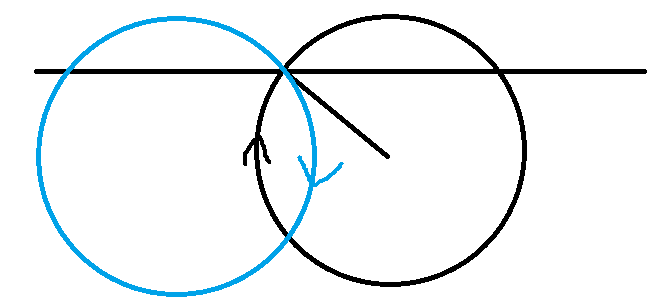

In [ ]:
draw_mp4(model)

./data/FixBounSpecRefl_uniform_0.010_2.00_10.h5


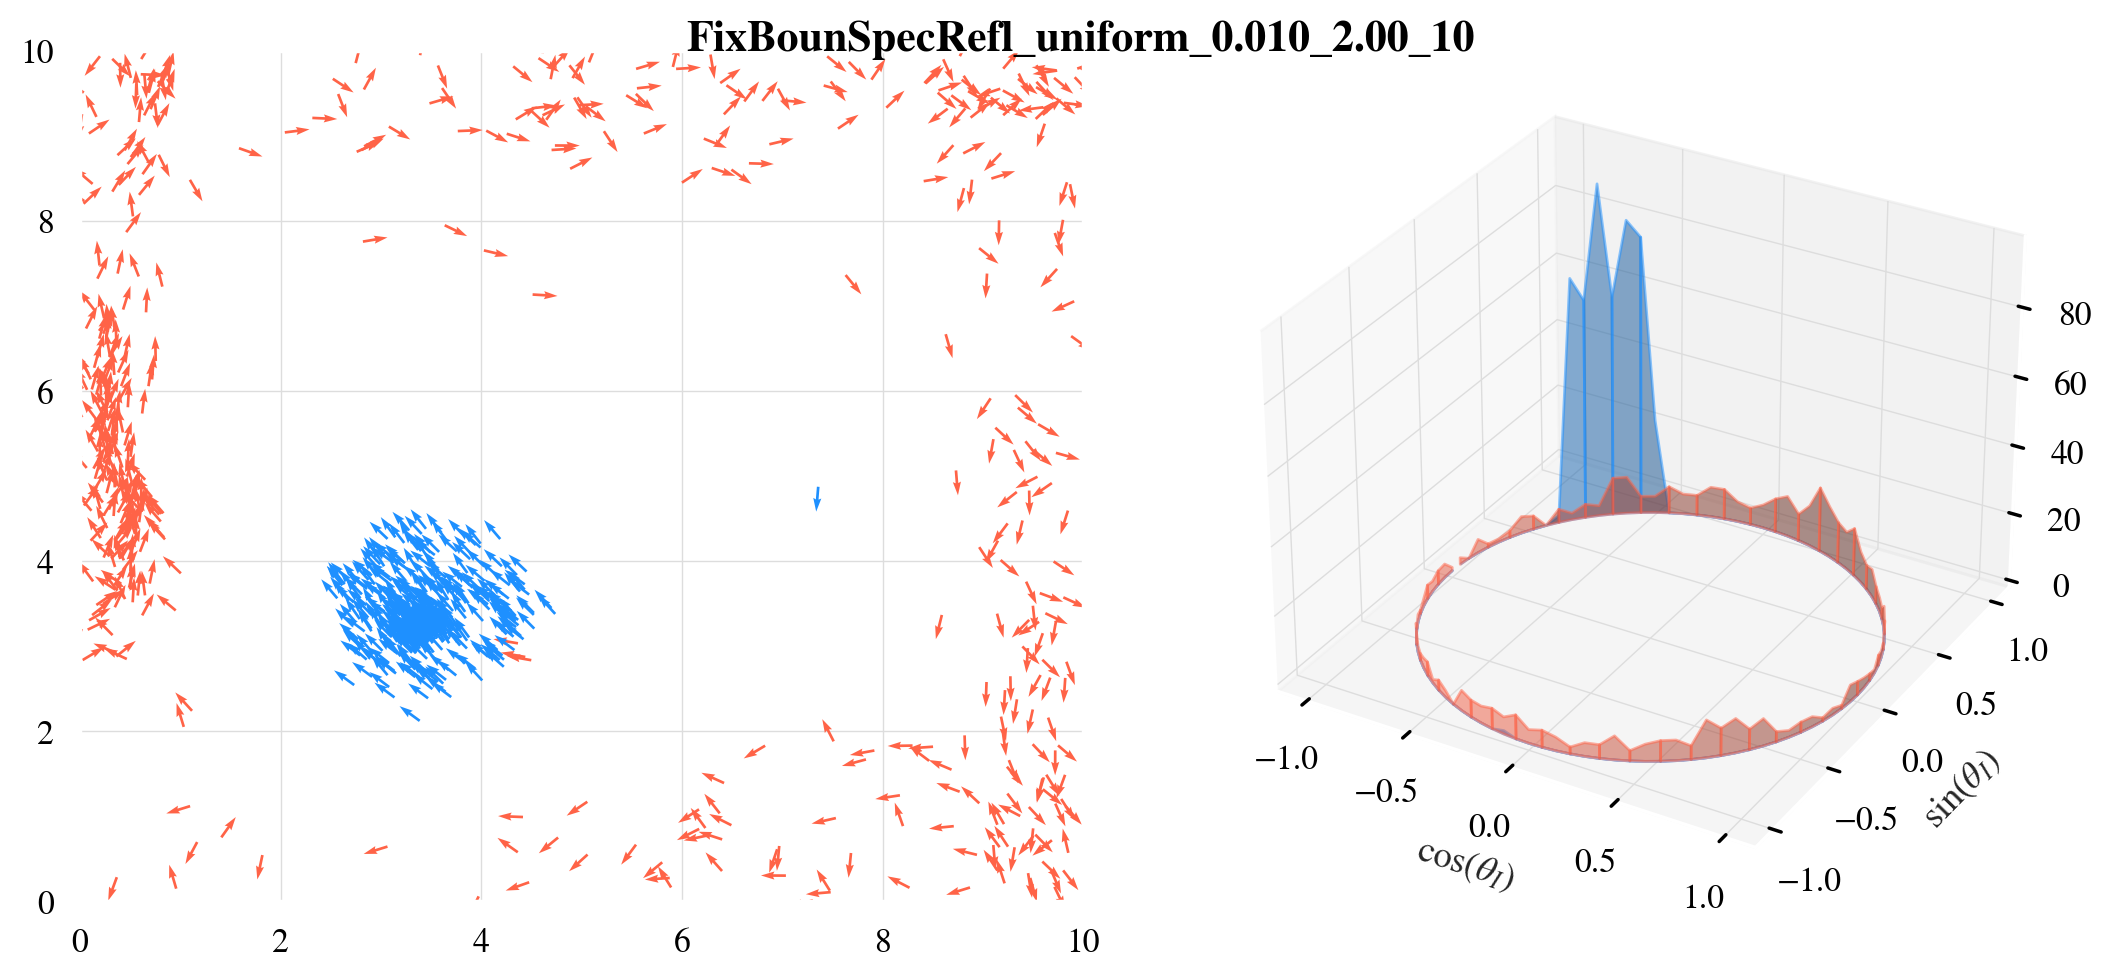

./data/FixBounSpecRefl_uniform_0.020_0.30_10.h5


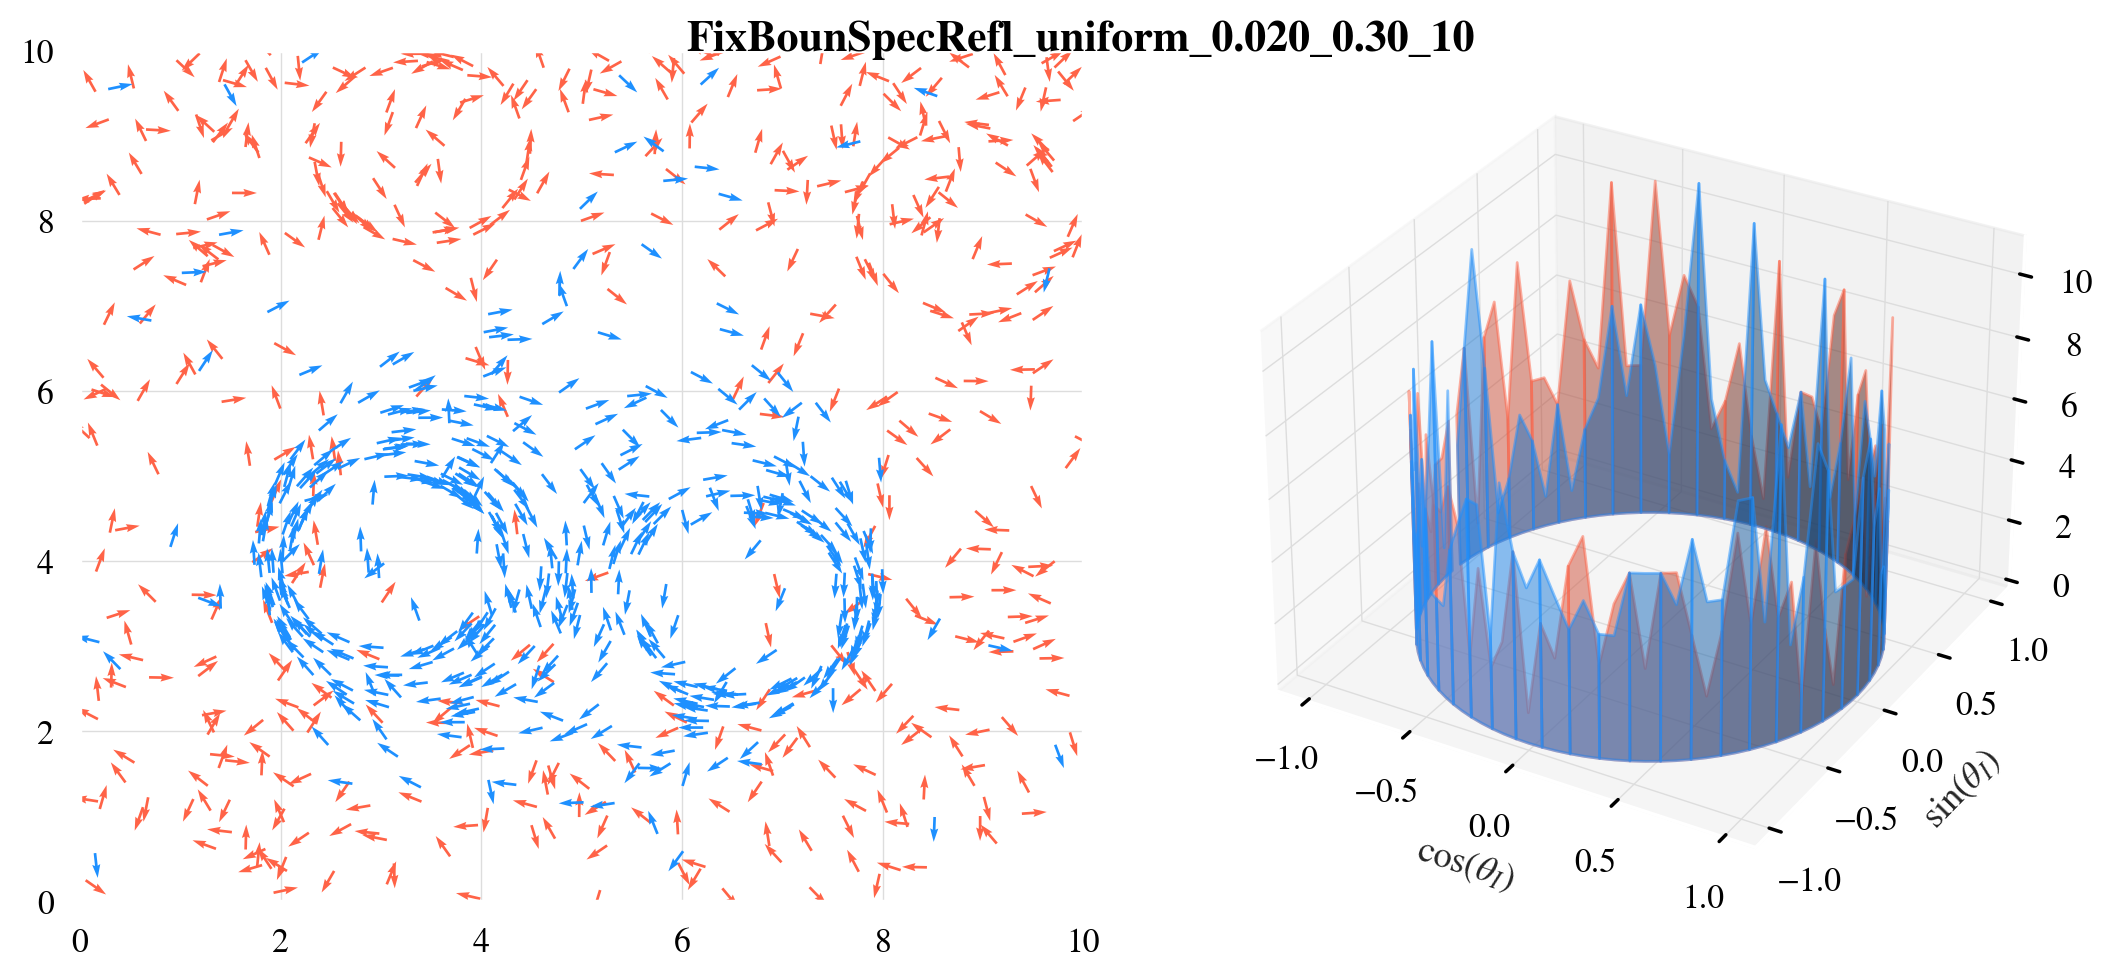

./data/FixBounSpecRefl_uniform_0.090_0.50_10.h5


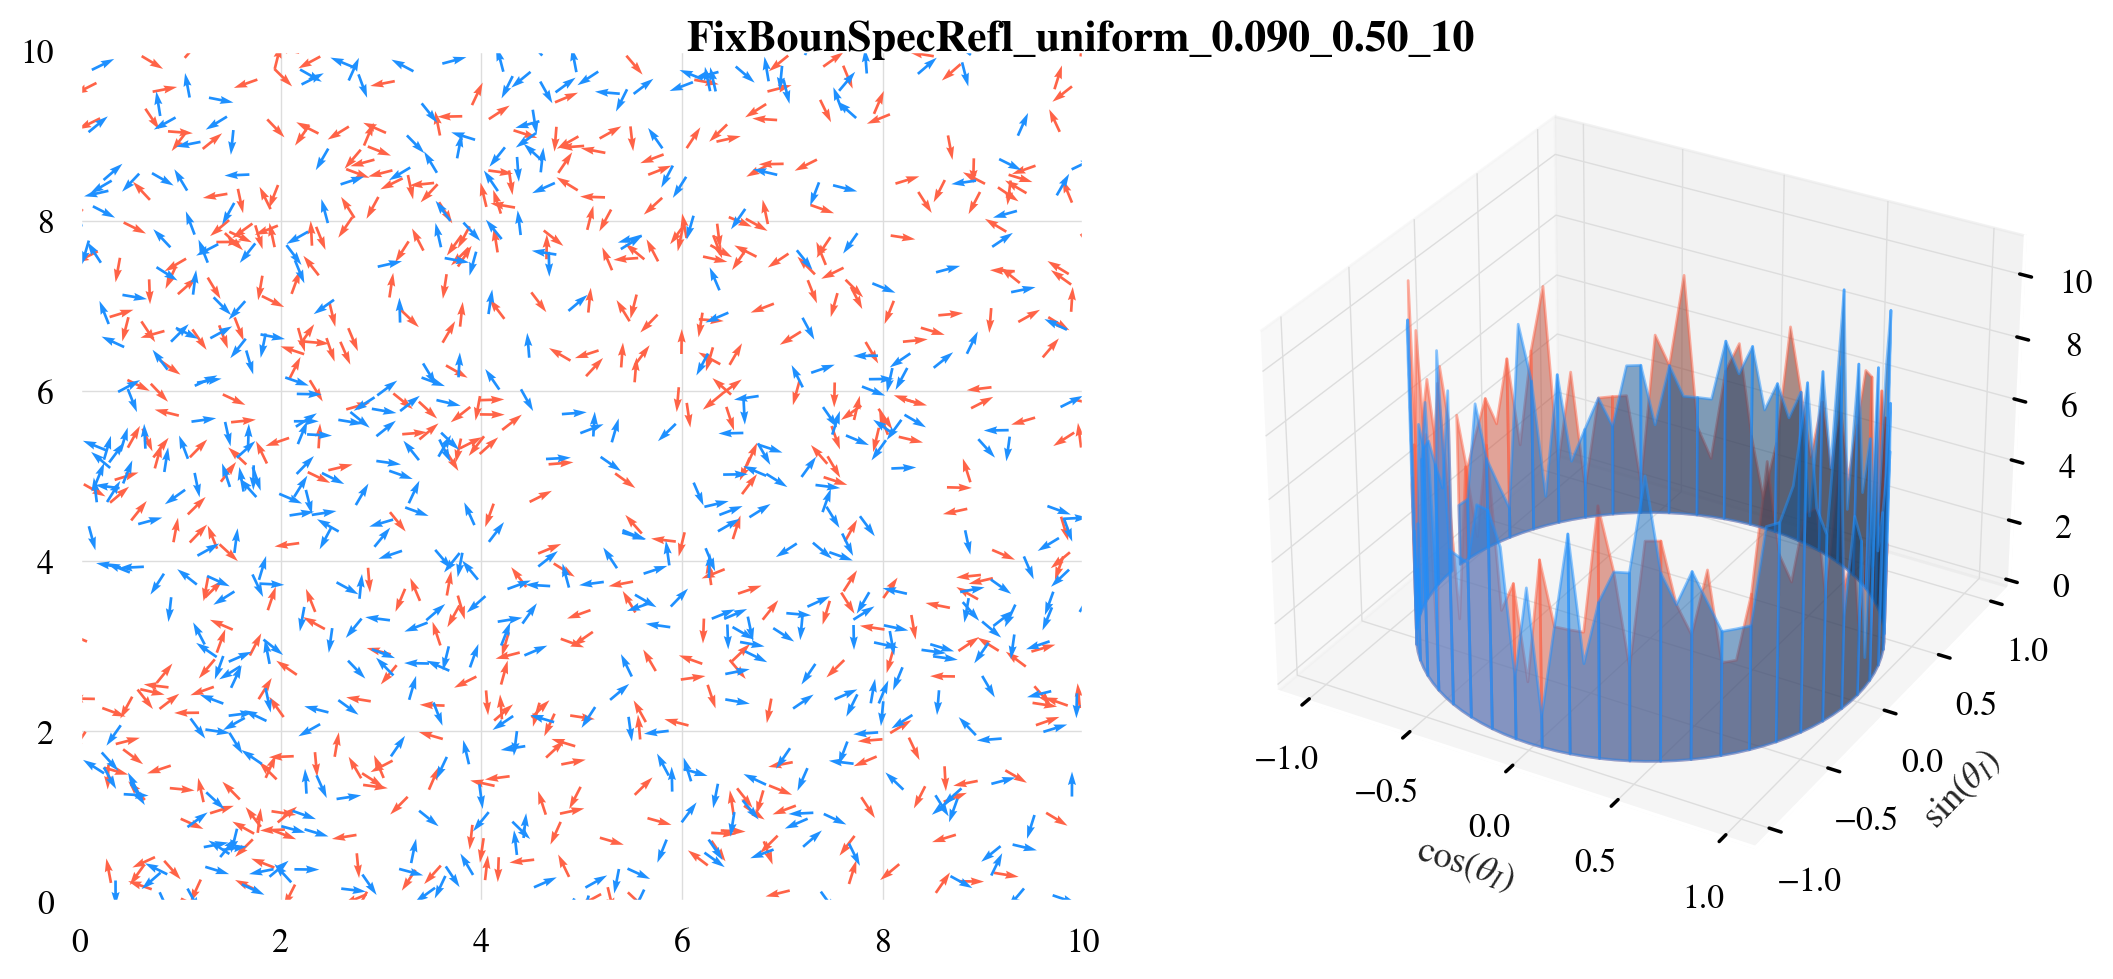

./data/FixBounSpecRefl_uniform_0.090_1.00_10.h5


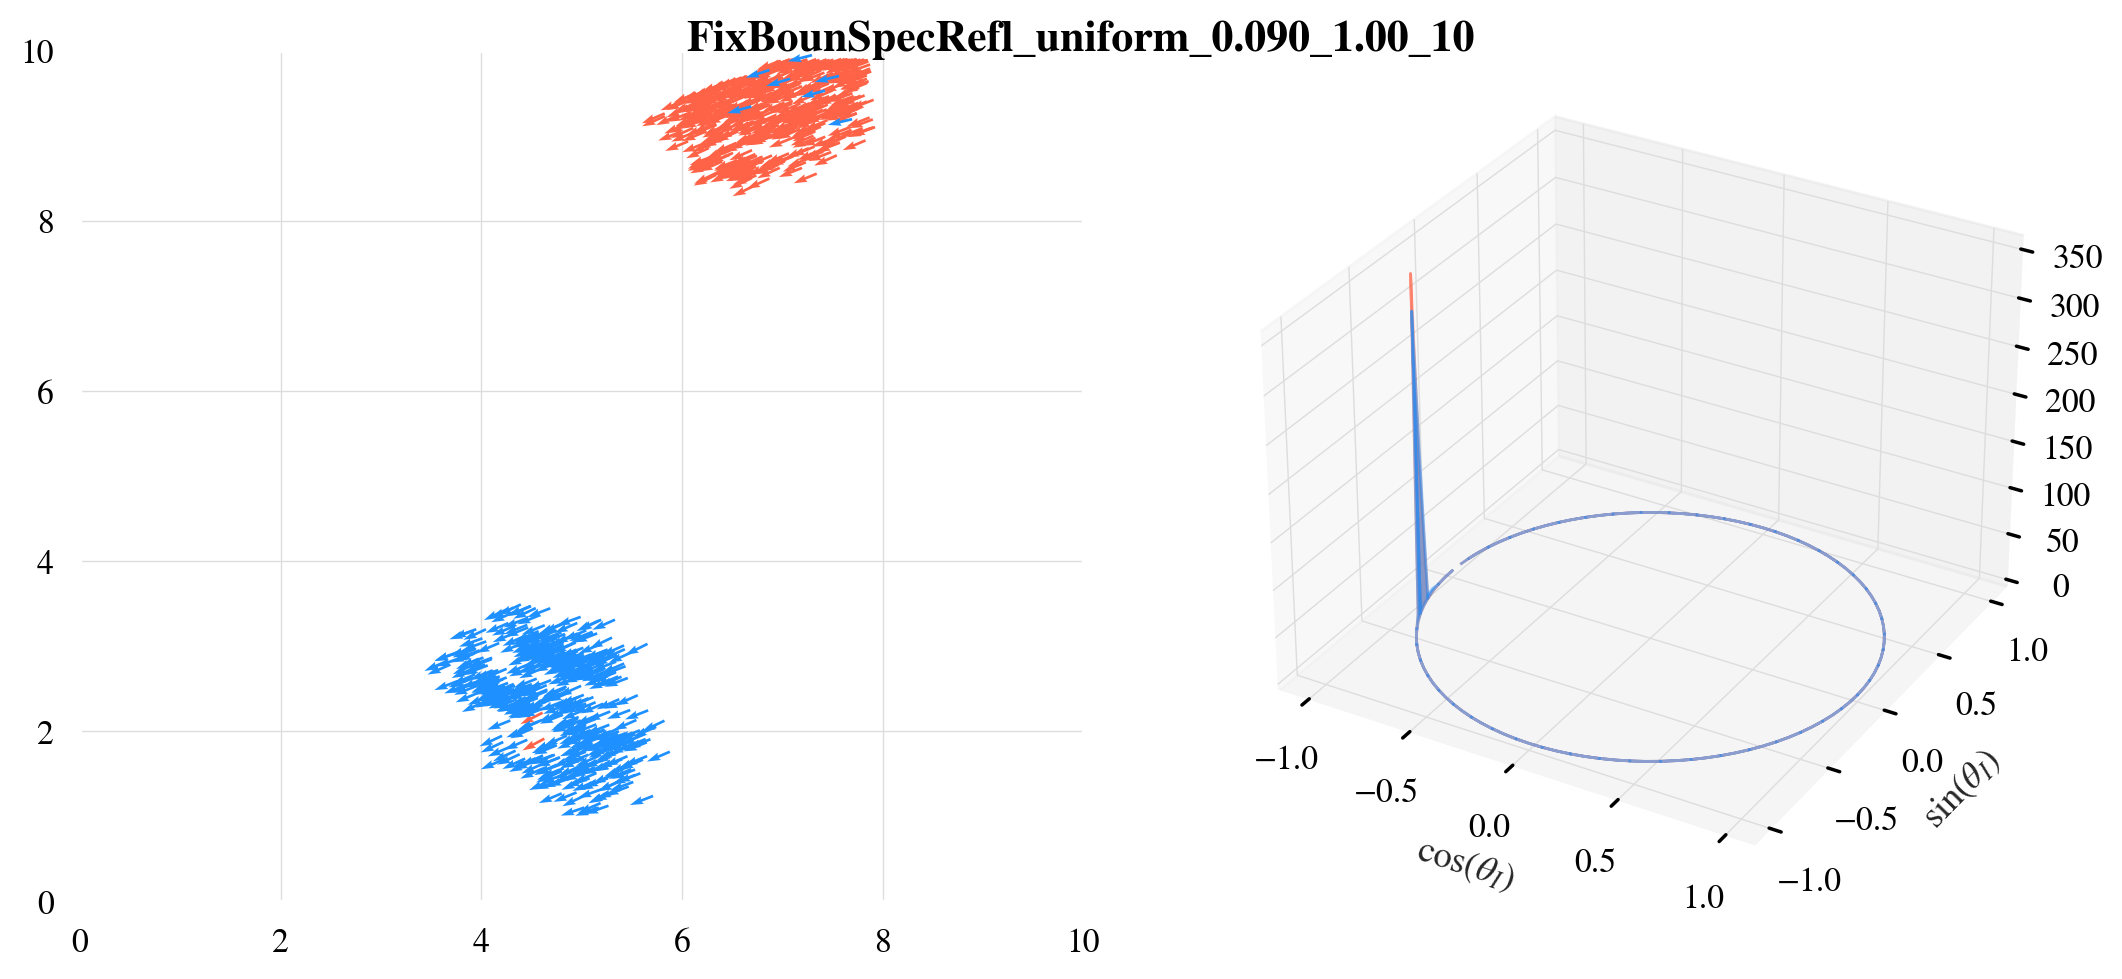

./data/FixBounSpecRefl_uniform_0.200_2.00_10.h5


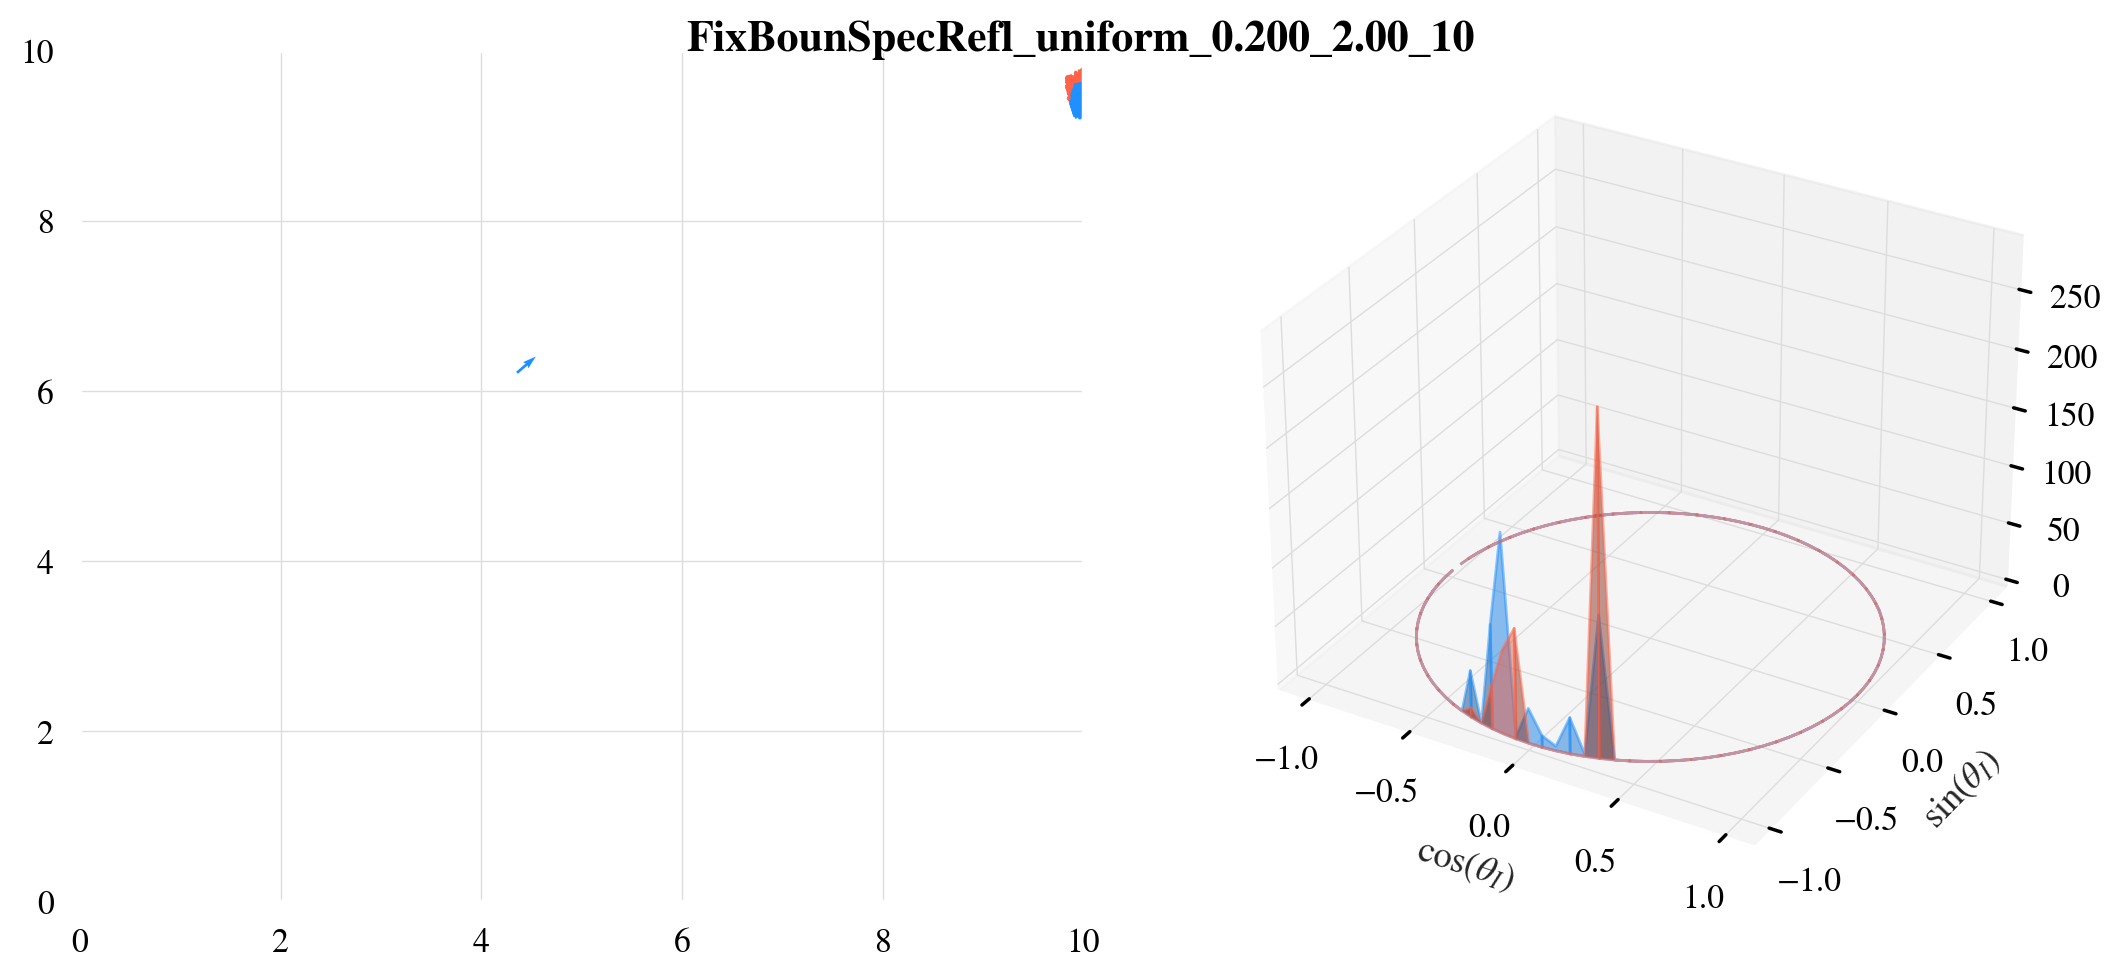

./data/FixBounSpecRefl_uniform_0.400_1.00_10.h5


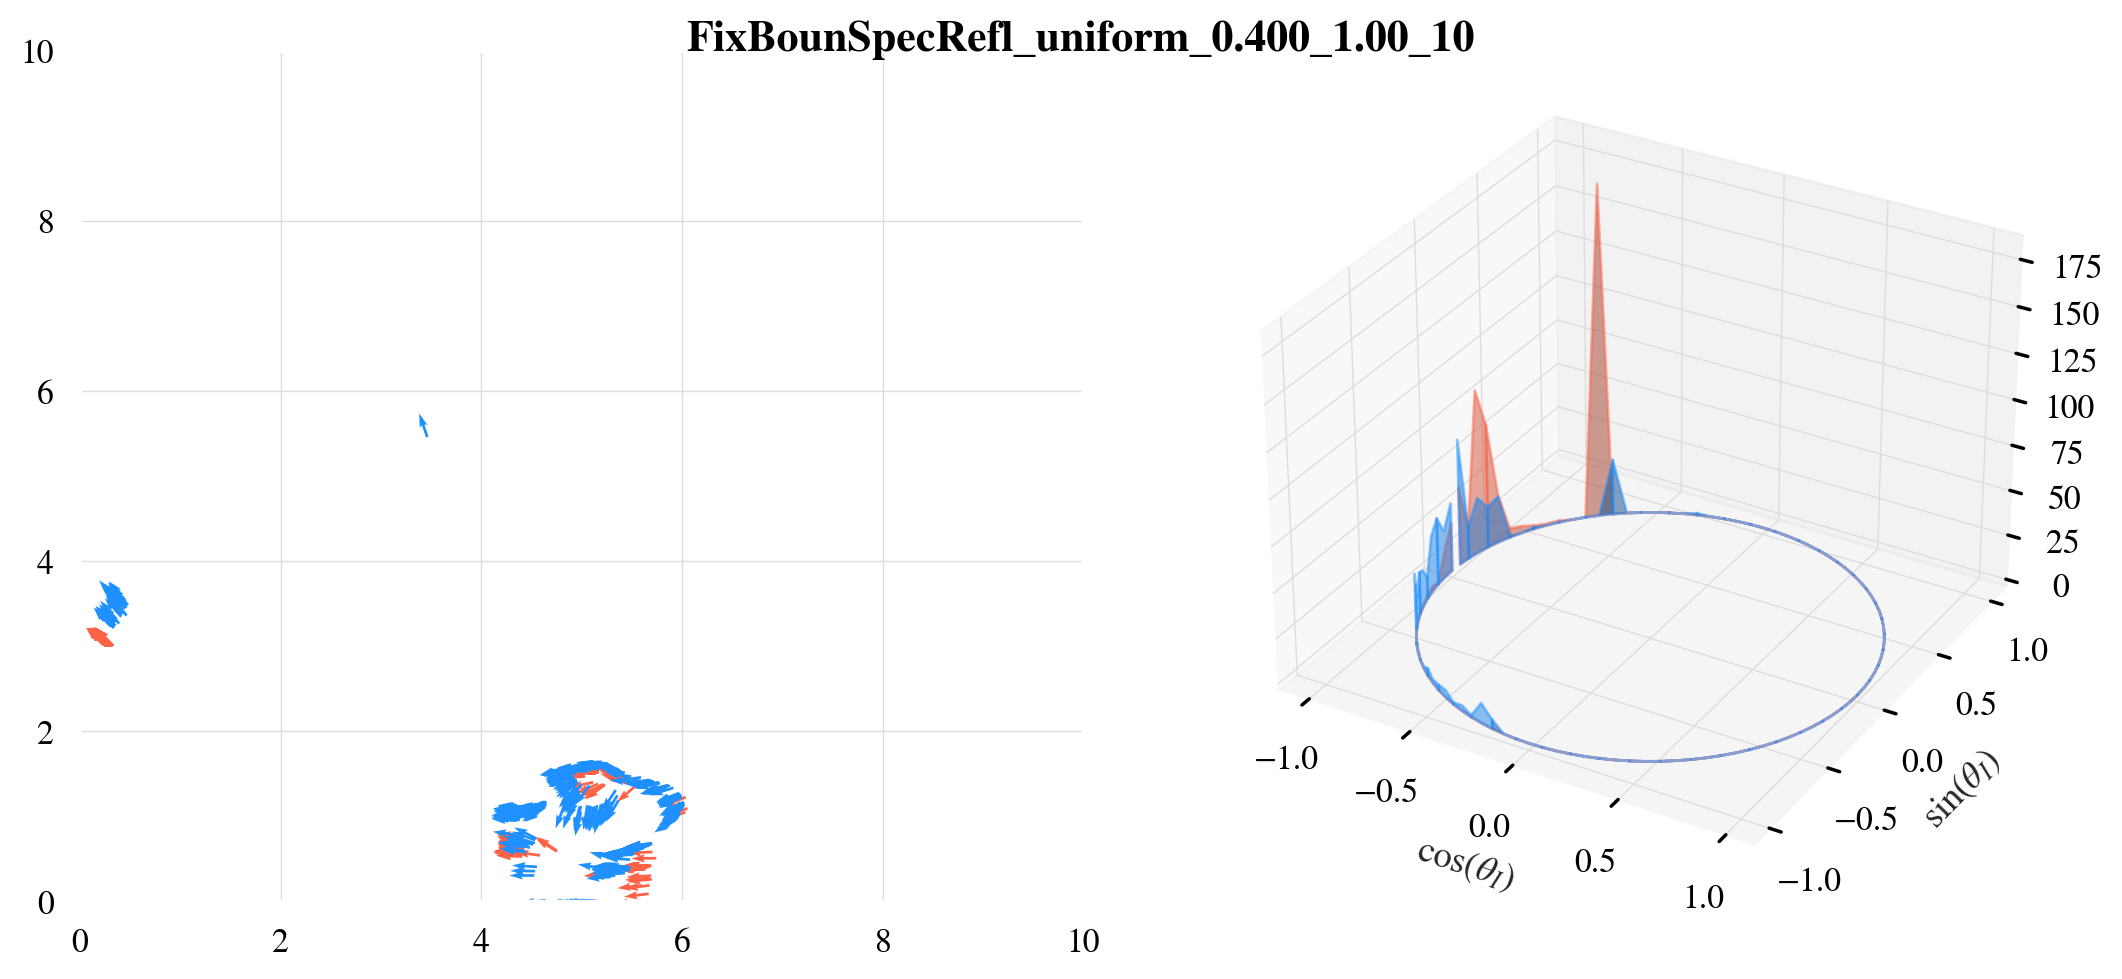

In [5]:
class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)
shift = 0

def plot_last(model):

    targetPath = f"./data/{model}.h5"
    print(targetPath)
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    positionX = totalPositionX[-1]
    phaseTheta = totalPhaseTheta[-1]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2, projection='3d')
    hist, bins = np.histogram(phaseTheta[class1], bins=100, range=(-np.pi, np.pi))
    # print(np.array([np.zeros_like(hist), hist]).shape)
    ax2.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]), 
        np.array([np.zeros_like(hist), hist]), 
        color='tomato', alpha=0.5, edgecolor="tomato"
    )
    hist, bins = np.histogram(phaseTheta[class2], bins=100, range=(-np.pi, np.pi))
    ax2.plot_surface(
        np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
        np.array([np.zeros_like(hist), hist]), 
        color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
    )
    ax2.set_xlabel(r"$\cos(\theta_I)$")
    ax2.set_ylabel(r"$\sin(\theta_I)$")

    plt.tight_layout()
    plt.suptitle(f"{model}")
    # plt.savefig(f"./figs/{model}_2d_circle.png", dpi=200)
    plt.show()

models = [
    FixBounSpecRefl(strengthLambda=0.01, distanceD0=2, agentsNum=1000, tqdm=True, savePath="./data", overWrite=True),
    FixBounSpecRefl(strengthLambda=0.02, distanceD0=0.3, agentsNum=1000, tqdm=True, savePath="./data", overWrite=True),
    FixBounSpecRefl(strengthLambda=0.09, distanceD0=0.5, agentsNum=1000, tqdm=True, savePath="./data", overWrite=True),
    FixBounSpecRefl(strengthLambda=0.09, distanceD0=1, agentsNum=1000, tqdm=True, savePath="./data", overWrite=True),
    FixBounSpecRefl(strengthLambda=0.2, distanceD0=2, agentsNum=1000, tqdm=True, savePath="./data", overWrite=True),
    FixBounSpecRefl(strengthLambda=0.4, distanceD0=1, agentsNum=1000, tqdm=True, savePath="./data", overWrite=True)
]

for model in models:
    plot_last(model)